In [107]:
import mat73
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [108]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [109]:
path = os.path.join(DATA_DIR, 'split_data')
#loading
train_features = pd.read_pickle(os.path.join(path, 'train_features_sensor.pkl'))
test_features = pd.read_pickle(os.path.join(path, 'test_features_sensor_classification.pkl'))
train_labels = pd.read_pickle(os.path.join(path, 'train_labels_classification.pkl'))
test_labels = pd.read_pickle(os.path.join(path, 'test_labels_classification.pkl'))

train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

In [110]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

## DATA NORMALISATION

In [111]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 8505) (481, 8505)


## PCA

In [112]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 242) (481, 242)


In [113]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

## Metrics

In [114]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["micro"] = auc(recall["micro"], precision["micro"])
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
    average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")

#     average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["macro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["macro"]

In [115]:
def brier_multi(targets, probs):
    return np.mean(np.mean((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## MODELS

In [116]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [117]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [118]:
# specify runs here
n = 10

## RANDOM BASELINE

### Shuffling

In [119]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

In [120]:
# save predictions to csv file
predicted_labels_shuffled = asarray(predicted_labels_shuffled)
savetxt('predicted_labels_shuffled.csv', predicted_labels_shuffled, delimiter=',')

### Always Zero Baseline

In [121]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_always_zero = np.zeros_like(test_labels)
    # add noise
    noise = np.random.rand(test_labels.shape[0], test_labels.shape[1])
    predicted_labels_always_zero = predicted_labels_always_zero + 1e-4*noise
    
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_always_zero)
    pr = plot_pr_curve(test_labels, predicted_labels_always_zero)
    roc = plot_roc_curve(test_labels, predicted_labels_always_zero)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Always Zero Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Always Zero Baseline')


In [122]:
# save predictions to csv file
predicted_labels_always_zero = asarray(predicted_labels_always_zero)
savetxt('predicted_labels_always_zero.csv', predicted_labels_always_zero, delimiter=',')

### Label Proportion Baseline

In [123]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    
    predicted_labels_proportion = [np.mean(train_labels == 1, axis=0)]*test_labels.shape[0]
    predicted_labels_proportion = np.array(predicted_labels_proportion)

    #add noise
    noise = np.random.randn(test_labels.shape[0], test_labels.shape[1])
    predicted_labels_proportion = predicted_labels_proportion + 1e-4*noise
    
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_proportion)
    pr = plot_pr_curve(test_labels, predicted_labels_proportion)
    roc = plot_roc_curve(test_labels, predicted_labels_proportion)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Proportion Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Proportion Baseline')

In [124]:
# save predictions to csv file
predicted_labels_proportion = asarray(predicted_labels_proportion)
savetxt('predicted_labels_proportion.csv', predicted_labels_proportion, delimiter=',')

## MULTI OUTPUT CLASSIFIER

In [125]:
%%capture
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier() 
lg = LogisticRegression()
models = [lg, forest]
number_of_bootstraps = 10
seed_value = 7
predictions = {}

for model in models:
    if str(model) == "RandomForestClassifier()":
        name = 'RandFor'  
    elif str(model) == "LogisticRegression()":
        name = 'LogReg'

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        predictions[str(model)] = predicted_labels
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MOC-'+str(name))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'MOC-'+str(name))

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [126]:
predicted_labels = predictions['RandomForestClassifier()']
# save predictions to csv file
savetxt('predicted_labels_MOCRandomForestClassifier.csv', predicted_labels, delimiter=',')

In [127]:
predicted_labels = predictions['LogisticRegression()']
# save predictions to csv file
savetxt('predicted_labels_MOCLogisticRegression.csv', predicted_labels, delimiter=',')

## Label Powerset

In [128]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)
    
    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)
    
    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-LogReg')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-LogReg')

In [129]:
from numpy import array
from scipy.sparse import csr_matrix

# reconstruct dense matrix
B = predicted_labels_lp.todense()
print(B)

[[0.19404104 0.84351634 0.04661499 ... 0.12669482 0.2407561  0.14123702]
 [0.53008587 0.65077698 0.10687727 ... 0.35896872 0.43661126 0.23701359]
 [0.50546014 0.37308831 0.08659643 ... 0.2586445  0.3434249  0.04979859]
 ...
 [0.53968765 0.44461958 0.03079845 ... 0.02461284 0.11775024 0.02952983]
 [0.29022837 0.30605087 0.06115074 ... 0.01962377 0.06041341 0.49974218]
 [0.05733045 0.93527736 0.06927719 ... 0.07248747 0.13660477 0.11370867]]


In [130]:
# save predictions to csv file
predicted_labels_lp = asarray(B)
savetxt('predicted_labels_LP_logreg.csv', B, delimiter=',')

In [131]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-RandFor')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-RandFor')

In [132]:
   predicted_labels_lp

<481x8 sparse matrix of type '<class 'numpy.float64'>'
	with 3848 stored elements in List of Lists format>

In [133]:
from numpy import array
from scipy.sparse import csr_matrix

# reconstruct dense matrix
B = predicted_labels_lp.todense()
print(B)

[[0.41 0.53 0.09 ... 0.23 0.44 0.28]
 [0.27 0.53 0.15 ... 0.21 0.46 0.18]
 [0.39 0.56 0.16 ... 0.11 0.38 0.23]
 ...
 [0.28 0.55 0.18 ... 0.1  0.32 0.14]
 [0.35 0.7  0.2  ... 0.21 0.41 0.21]
 [0.3  0.61 0.18 ... 0.19 0.49 0.3 ]]


In [134]:
# save predictions to csv file
predicted_labels_lp = asarray(B)
savetxt('predicted_labels_LP_randfor.csv', B, delimiter=',')

In [135]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.13887733887733889 0.22642931392931395 0.16450303274428274 0.6068956707709432 0.3070624360286591 0.4077914213600555 0.27717429434061547 0.527049478097174 0.004341083787488795 0.0020131528489463917 0.0003436440374315573 0.007498721964591976 0.00525905120927947 0.006202219326551722 0.005697224717559376 0.01046630516879421


## Visualisation

In [136]:
%matplotlib inline

[0.046361746361746364, 0.09563409563409564, 0.14137214137214138, 0.09002079002079003, 0.12723492723492724, 0.10062370062370063, 0.13887733887733889] [(0.03097713097713098, 0.06143451143451144), (0.09563409563409564, 0.09563409563409564), (0.14137214137214138, 0.14137214137214138), (0.07785862785862786, 0.1055093555093555), (0.11205821205821206, 0.14293139293139293), (0.08295218295218296, 0.12214137214137213), (0.13284823284823286, 0.14345114345114346)]


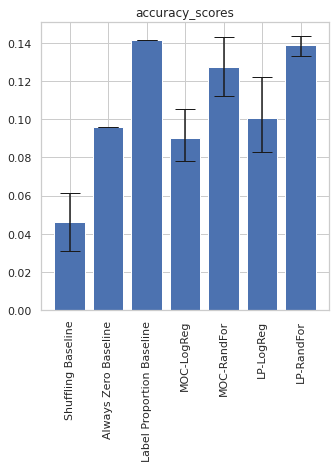

[0.326039501039501, 0.2538981288981289, 0.2245322245322246, 0.2650987525987526, 0.2280925155925156, 0.26008316008316007, 0.22642931392931395] [(0.3206860706860707, 0.3338357588357588), (0.2538981288981289, 0.2538981288981289), (0.22453222453222454, 0.22453222453222454), (0.25809511434511434, 0.27214137214137213), (0.22257016632016635, 0.23330301455301455), (0.24819386694386697, 0.2689319126819127), (0.22438929313929315, 0.22989864864864867)]


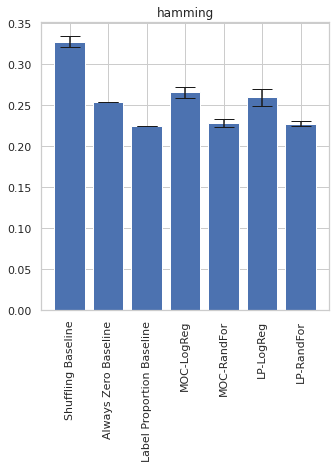

[0.326039501039501, 0.25387285882521776, 0.16401983868568204, 0.18456579100335505, 0.16704829261954263, 0.1880668528808735, 0.16450303274428274] [(0.3206860706860707, 0.3338357588357588), (0.25387244099882406, 0.2538735542815707), (0.16401827822378556, 0.16402211727672913), (0.17919010439018618, 0.1887848665909994), (0.16417554313929317, 0.1696285966735967), (0.18004178453135594, 0.19352665436839517), (0.16406114215176715, 0.16505698544698544)]


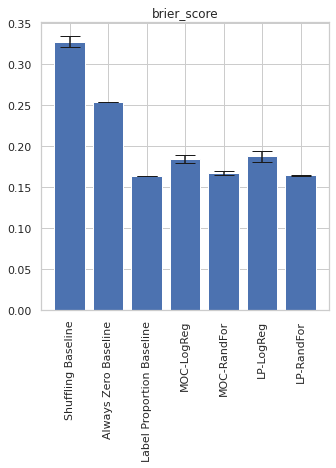

[0.3579324462640737, 1.0, 0.6174636174636173, 0.46649564601361454, 0.5986345229165052, 0.4776434517158773, 0.6068956707709432] [(0.3425793244626407, 0.368474923234391), (1.0, 1.0), (0.6174636174636174, 0.6174636174636174), (0.4350284495021337, 0.48459803213859765), (0.5586574284695497, 0.6372829260796066), (0.4289749417895554, 0.5032640949554896), (0.5941306787480777, 0.6147931318270239)]


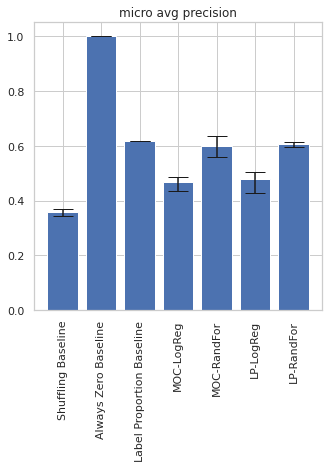

[0.3579324462640737, 0.0, 0.3039918116683725, 0.3425841054550169, 0.296245108429155, 0.32207069539226857, 0.3070624360286591] [(0.3425793244626407, 0.368474923234391), (0.0, 0.0), (0.3039918116683726, 0.3039918116683726), (0.3203370748643274, 0.36280073823986925), (0.28800239427961305, 0.31161571449041003), (0.2803591532679408, 0.3508212136409228), (0.2983111566018424, 0.3127430910951894)]


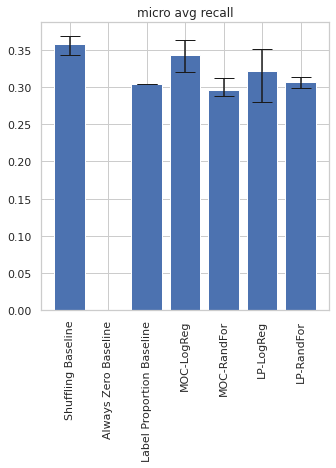

[0.3579324462640737, 0.0, 0.40740740740740744, 0.39495313293139933, 0.39622641317841967, 0.3846495750957502, 0.4077914213600555] [(0.3425793244626407, 0.36847492323439107), (0.0, 0.0), (0.40740740740740744, 0.40740740740740744), (0.36890526850795574, 0.4116923773044869), (0.3821596072602247, 0.41854913767736945), (0.33904861357980803, 0.41202826450458585), (0.3971928754116447, 0.41379216134320196)]


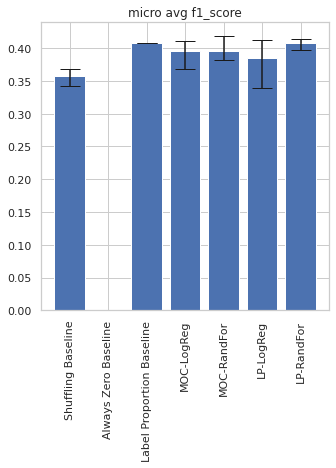

[0.25483562666342213, 0.2593613365951295, 0.26043364397711366, 0.3041715003963869, 0.28897090473972514, 0.29455359378357654, 0.27717429434061547] [(0.25111225590733466, 0.25833780678584617), (0.25214386430048225, 0.26989575222789663), (0.24911480982701367, 0.2741980992969071), (0.28877237464058825, 0.3215097293868264), (0.2723077659550853, 0.30634885943368295), (0.2733213127088693, 0.31120874581256186), (0.27091826673565605, 0.2862212646898654)]


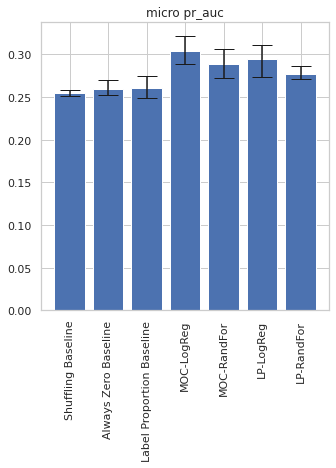

[0.4994787974989709, 0.49561796556699245, 0.49591932911187603, 0.5667798847727015, 0.5369357921561306, 0.5447125815043746, 0.527049478097174] [(0.4864287824865724, 0.5091168476875727), (0.4765026461900861, 0.5147518787195027), (0.47466209521574687, 0.5110333334553702), (0.552553174495123, 0.5831902630055469), (0.5223417042377355, 0.5515188267424616), (0.5289658002976451, 0.5657106127772888), (0.5119344531276765, 0.542686508052183)]


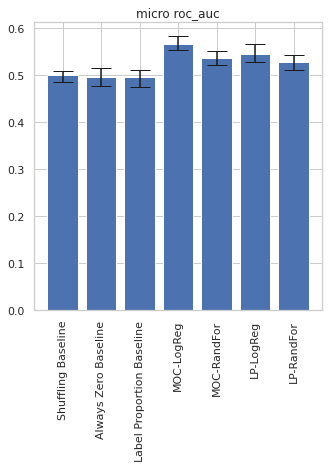

In [137]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

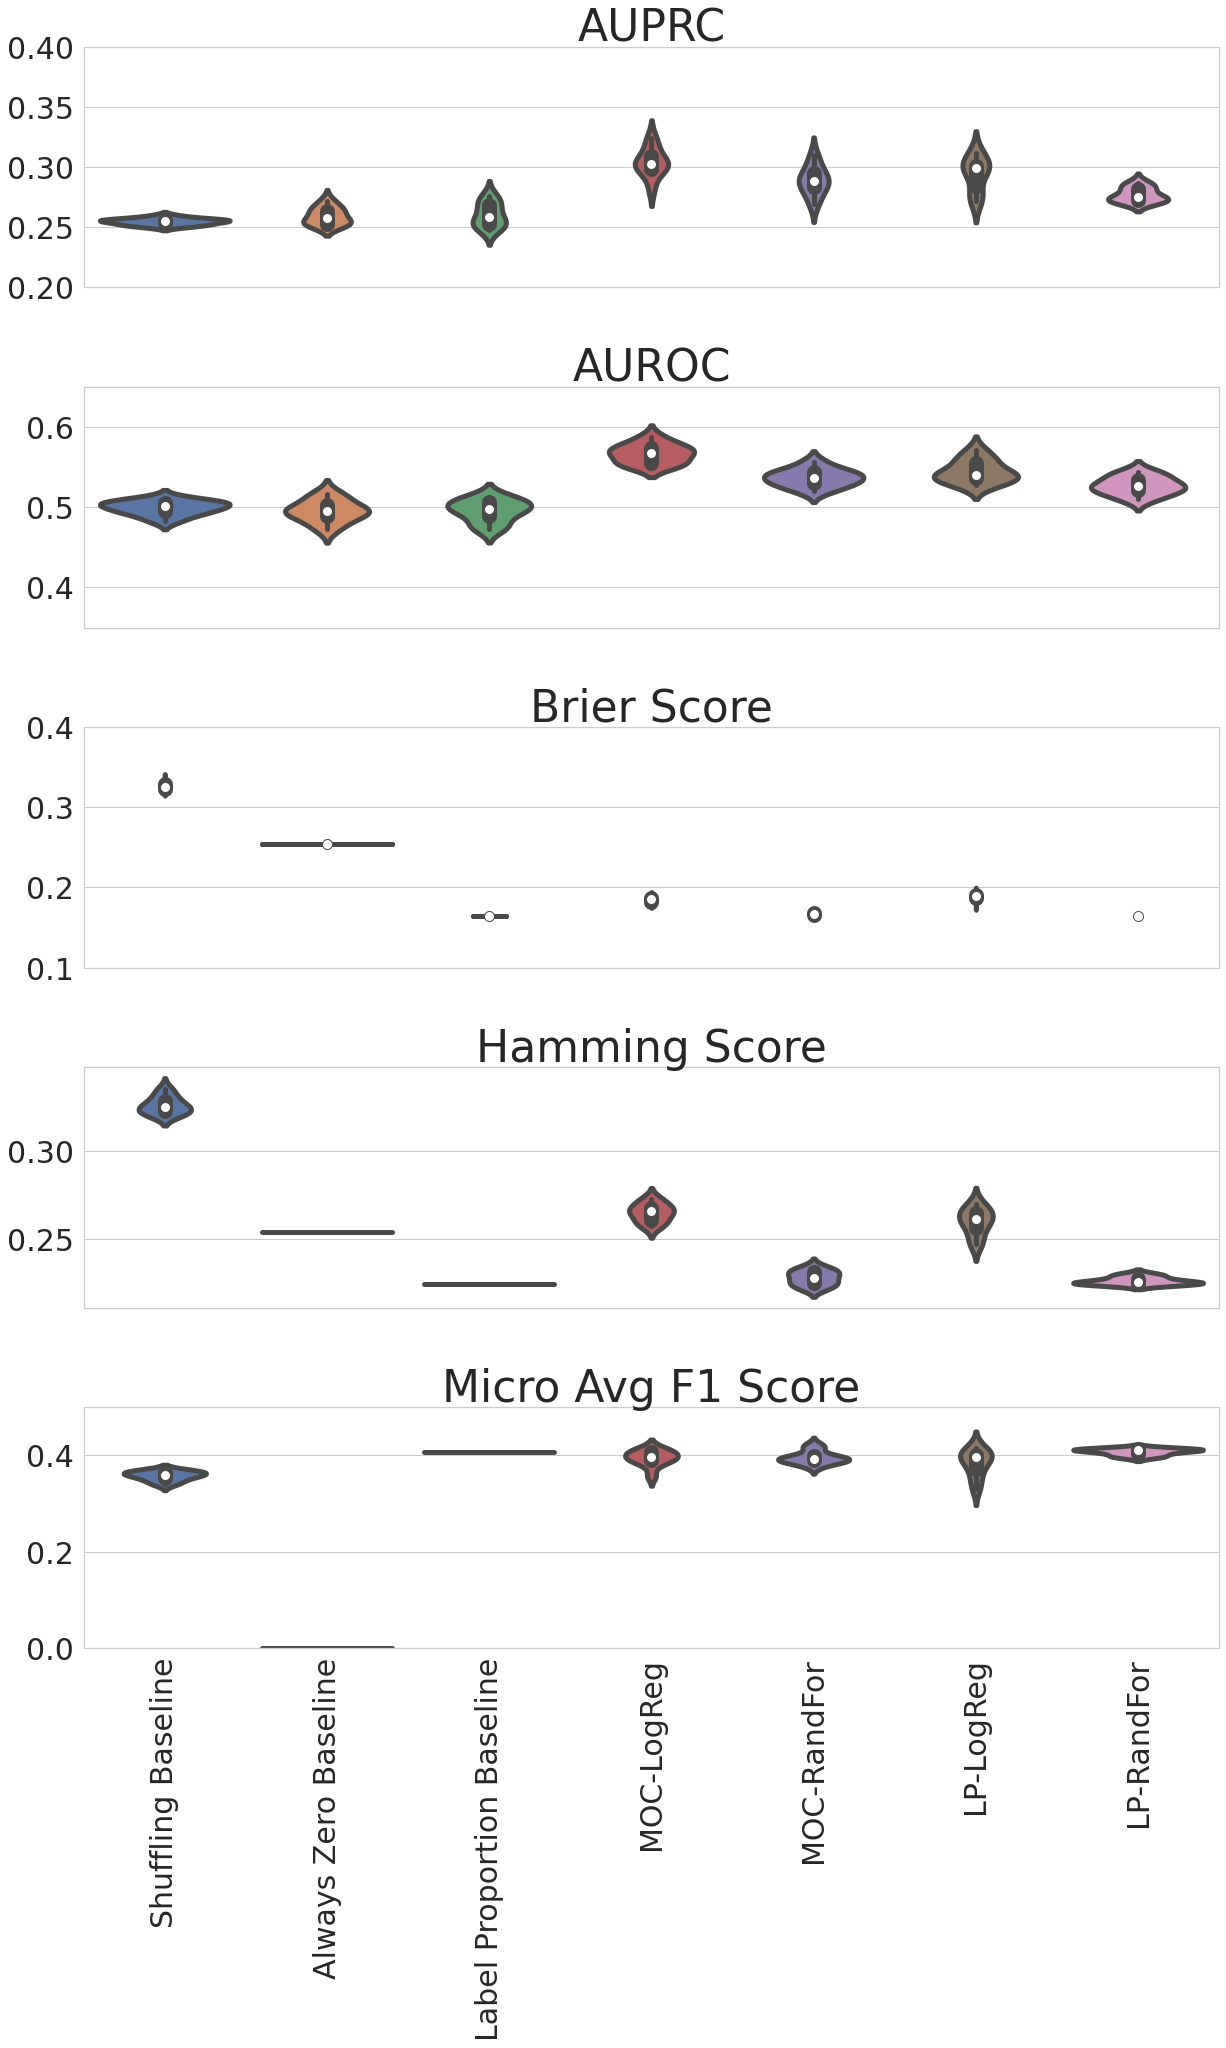

In [139]:
import seaborn as sns
#sns.set(style="whitegrid")

# plot
fig, axes = plt.subplots(5, 1, figsize=(18,30), sharex=True)

fig.suptitle("", fontsize = 30)
sns.violinplot(y=hamming_all, x=model_names_all, points=6 ,ax=axes[3], linewidth=5)
axes[3].set_title('Hamming Score',fontsize =  44)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
axes[2].set_ylim(0.0, 0.35)

axes[3].tick_params(axis='both', which='major', labelsize=30)


# plot
sns.violinplot(y=brier_score_all, x=model_names_all, ax=axes[2], linewidth=5)
axes[2].set_title('Brier Score', fontsize =  44)
plt.xticks(rotation=90)
axes[2].set_ylim(0.1, 0.4)

sns.set(rc = {'figure.figsize':(3,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)


axes[2].tick_params(axis='y', which='major', labelsize=30)



sns.violinplot(y=pr_auc_all, x=model_names_all, ax=axes[0], linewidth=5)
axes[0].set_title("AUPRC", fontsize =  44)
plt.xticks(rotation=90)
#plt.set(ylim=(0, 0.2)
sns.set(rc = {'figure.figsize':(18,18)})
sns.set(style="whitegrid")
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)

axes[0].tick_params(axis='y', which='major', labelsize= 30)


sns.violinplot(y=roc_auc_all, x=model_names_all, ax=axes[1], linewidth=5)
axes[1].set_title("AUROC", fontsize = 44)
plt.xticks(rotation=90)
plt.ylim([0,0.6])
axes[1].set_ylim(0.35, 0.65)

sns.set(rc = {'figure.figsize':(18,18)})
sns.set(style="whitegrid")
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
axes[0].set_ylim(0.2, 0.4)

axes[1].tick_params(axis='y', which='major', labelsize= 30)


sns.violinplot(y=f1_score_all, x=model_names_all,ax=axes[4], linewidth=5)
axes[4].set_title("Micro Avg F1 Score", fontsize = 44)
plt.xticks(rotation=90)
axes[4].set_ylim(0., 0.5)
axes[4].tick_params(axis='y', which='major', labelsize=30)

sns.set(rc = {'figure.figsize':(18,18)})
sns.set(style="whitegrid")
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
axes[1].tick_params(axis='y', which='major', labelsize= 30)

plt.tight_layout(pad=3.5)
